### Unsupervised Learning
**Unsupervised learning** techniques would help us discover similar sub-domains and recent popular research trends by performing clustering based on inclusion of keywords related to specific sub-domains. Clustering techniques include:
1. k-means clustering
2. Gaussian mixture model clustering
3. Density-based clustering

We have implemented Bag-of-words, TF-IDF, and BERT encodings using the words from ‘Title’ and ‘Abstract’ sections of the paper. We are using scikit’s feature_extraction libraries to construct our encodings.

In [54]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import pandas as pd
import os
import json
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from bag_of_words import Clustering
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import AutoTokenizer, AutoModel
import torch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Conferences
conf = ['acl_2017', 'arxiv.cs.ai_2007-2017', 'arxiv.cs.cl_2007-2017', 'arxiv.cs.lg_2007-2017', 'conll_2016', 'iclr_2017']

# JSON files to be parsed
dir_path    = '/Users/shashi/code/ML/CS-7641-ML-Project/data/'
train_path  = '/train/reviews/'
test_path   = '/test/reviews/'

In [21]:
tf_idf = Clustering()

# json_train_files = sorted([pos_json for pos_json in os.listdir(acl_train_path) if pos_json.endswith('.json')])
# json_test_files = sorted([pos_json for pos_json in os.listdir(acl_test_path) if pos_json.endswith('.json')])
json_train_files    = []
json_test_files     = []
N_training          = 0
N_testing           = 0
for c in conf:
    c_train_path    = dir_path + c + train_path
    c_test_path     = dir_path + c + test_path
    c_json_train    = sorted([pos_json for pos_json in os.listdir(c_train_path) if pos_json.endswith('.json')])
    c_json_test     = sorted([pos_json for pos_json in os.listdir(c_test_path) if pos_json.endswith('.json')])
    c_json_train    = [c_train_path + s for s in c_json_train]
    c_json_test     = [c_test_path + s for s in c_json_test]
    json_train_files.append(c_json_train)
    json_test_files.append(c_json_test)
    N_training += len(c_json_train)
    N_testing += len(c_json_test)

In [22]:
# Creating the dataset in string format
train_data  = []
test_data   = []
train_title = []
test_title  = []

for c in json_train_files:
    title, data = tf_idf.parse_json_files(c)
    train_data.extend(data)
    train_title.extend(title)

for c in json_test_files:
    title, data = tf_idf.parse_json_files(c)
    test_data.extend(data)
    test_title.extend(title)

merged_data = []
merged_data.extend(train_data)
merged_data.extend(test_data)

### Bag-of-words (BOW)

We chose this model because it is the simplest numerical representation of text. For constructing this, we are using scikit’s CountVectorizer to tokenize the sentences from ‘Title’ and ‘Abstract’ into a matrix of token counts. Then we are using scikit’s fit_transform() api to learn the vocabulary dictionary and return the document-term matrix. We are using pandas dataframes to store this matrix.

During preprocessing the data, we are excluding English stop words and numbers from tokenizing because they do not contribute for analyzing the sub-domain.

As we can see, there are total 11727 papers, including both training and testing data, and the encoding resulted in 29445 unique words.

In [23]:
# Getting bag of words data structure
CountVec = CountVectorizer(ngram_range=(1,1), preprocessor=tf_idf.preprocess_text, stop_words='english')
Count_data = CountVec.fit_transform(merged_data)
X_train = Count_data[0:len(train_data)]
X_test = Count_data[len(train_data):]
# print(CountVec.get_feature_names())
cv_dataframe=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names_out())
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
display(cv_dataframe.head(5).loc[:,cv_dataframe.head(5).any()])
# print(cv_dataframe.head(5).loc[:,cv_dataframe.head(5).any()].iloc[:, : 10].to_markdown())
# print(cv_dataframe)

,annotation,answering,attention,base,based,bridge,cross,detection,effective,embedding,...,overlapping,projection,prototype,question,recognition,relation,representation,supervised,text,weakly
0,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,1,0,...,0,1,0,0,1,0,1,1,0,1
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,0,1,0,1,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0


### Clustering on BOW model

Now, we will be using the BOW encoding for clustering similar sub-domain papers together. For this we are using K-means clustering algorithm and we are determining the optimal number of clusters using the popular elbow curve method.

From the below elbow curve, we are choosing $K=6$ as the optimal number of clusters for our final clustering model.

Inertia which is sum of squared distances of samples to their closest cluster center is also obtained once the training is done.

1512861.125


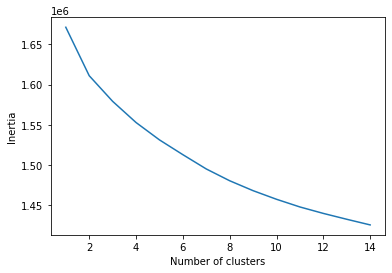

In [48]:
# Cluster documents based on BOW model
bow_distortions = []
K = range(1,15)

for k in K:
    bow_model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10)
    bow_model.fit(X_train)
    bow_distortions.append(bow_model.inertia_)

plt.plot(K, bow_distortions)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
# print(distortions)

# Choosing the best k from elbow method.
true_k = 6
bow_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=10)
bow_model.fit(X_train)
bow_inertia = bow_model.inertia_
print(bow_inertia)

### Clustering Analysis
To understand what each cluster signifies in terms of sub-domain, we are obtaining top terms per cluster. To analyze in a better way, word clouds for these are generated.

As you can see from the word clouds for each cluster, <br>
Cluster 0: <br>
Cluster 1: <br>
Cluster 2: <br>
Cluster 3: <br>
Cluster 4: <br>
Cluster 5: <br>

Once the model is trained, we are clustering the papers in our testing set and the sample prediction is as shown below.

Top terms per cluster:


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


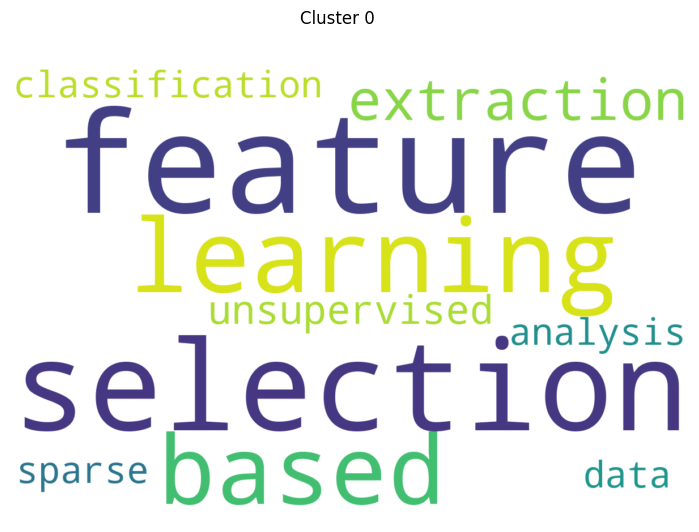

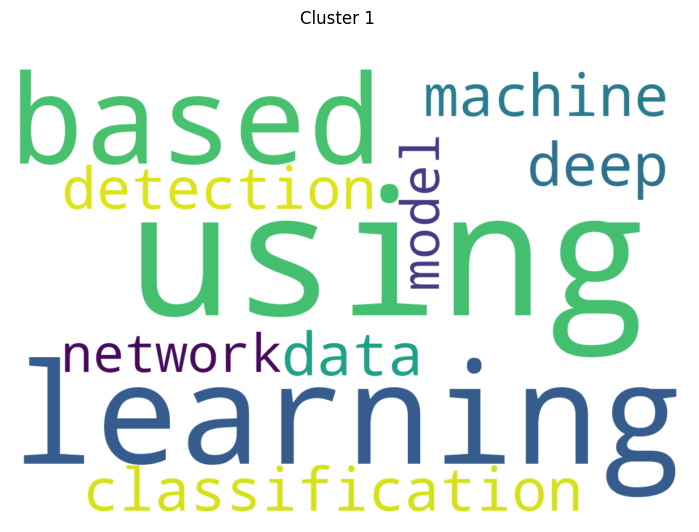

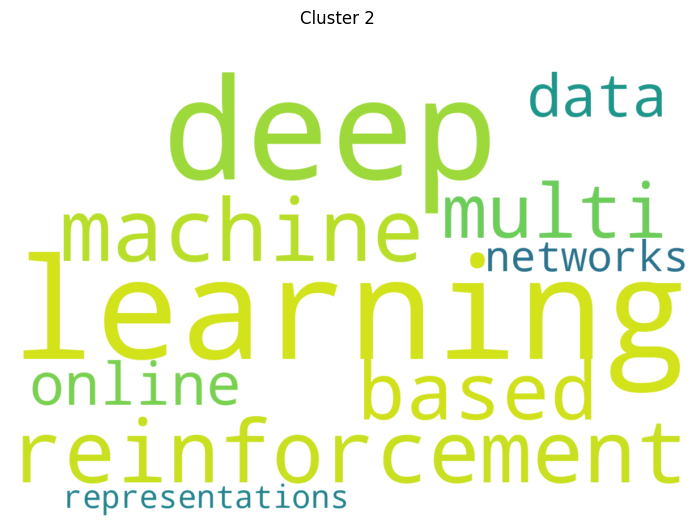

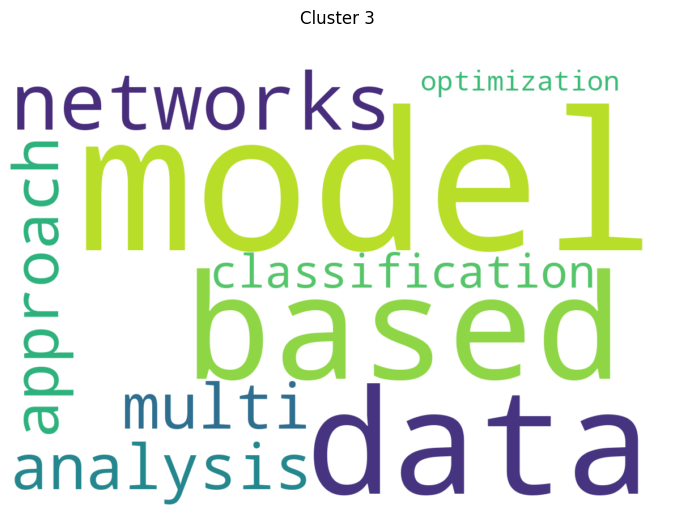

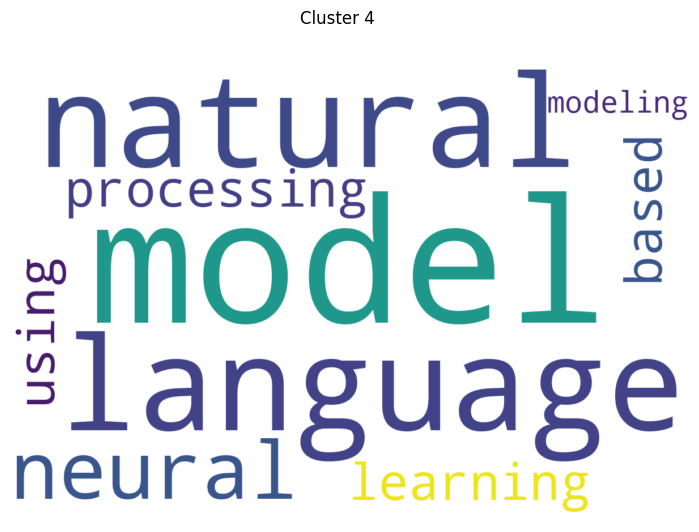

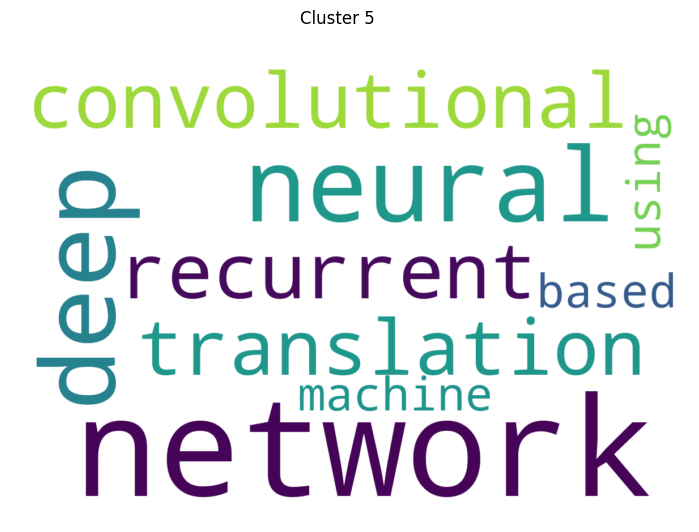

In [25]:
# Print top terms per cluster and generate word clouds for BOW model
print("Top terms per cluster:")
bow_order_centroids = bow_model.cluster_centers_.argsort()[:, ::-1]
terms = CountVec.get_feature_names()
for i in range(true_k):
    # print("Cluster %d:" % i)
    words = ""
    for ind in bow_order_centroids[i, :10]:
        words = words + terms[ind] + " "
        # print (' %s' % terms[ind])
    wordcloud = WordCloud(width=1200, height=800, background_color="white").generate(words)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    fig.suptitle(f"Cluster {i}")
    plt.show()

In [26]:
# Testing the Clustering based on BOW model
# Predict the cluster association of each paper

prediction = bow_model.predict(X_test)
print(X_train.shape)
print(X_test.shape)
df = pd.DataFrame(list(zip(test_title, prediction)), columns =['Title', 'Cluster ID'])
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# display(df)
print(df.head(10).loc[:,df.head(10).any()].to_markdown())
# display(df.loc[df['Cluster ID'] == 1])

(11090, 9172)
(637, 9172)
|    | Title                                                                                              |   Cluster ID |
|---:|:---------------------------------------------------------------------------------------------------|-------------:|
|  0 | Evaluation Metrics for Machine Reading Comprehension: Prerequisite Skills and Readability          |            3 |
|  1 | A Neural Local Coherence Model                                                                     |            5 |
|  2 | Neural Modeling of Multi-Predicate Interactions for Japanese Predicate Argument Structure Analysis |            5 |
|  3 | Neural Disambiguation of Causal Lexical Markers based on Context                                   |            5 |
|  4 | Chunk-based Decoder for Neural Machine Translation                                                 |            5 |
|  5 | What do Neural Machine Translation Models Learn about Morphology?                                  |      

### TF-IDF Encoding

This model is a numeric statistic that is intended to reflect how important a word is to a document. Term frequency is a measure of how frequently a term appears in a document and IDF is a measure of how important a term is. In contrast to BOW, this model derives information on the most and least important words, and hence is expected to perform better. Implementing this is like the BOW approach, except that we will be using a different tokenizer for our data. We are using scikit’s TfidfVectorizer with English stop-words to avoid commonly used English words.

A sample of our TF_IDF encoding is as follows:

In [64]:
# Getting tf-idf data structure
# Vectorize the text
vectorizer = TfidfVectorizer(preprocessor=tf_idf.preprocess_text, stop_words='english')
X = vectorizer.fit_transform(merged_data)
X_train = X[0:len(train_data)]
X_test = X[len(train_data):]
tf_idf_df=pd.DataFrame(X_train.toarray(),columns=vectorizer.get_feature_names_out())
display(tf_idf_df.head(5).loc[:,tf_idf_df.head(5).any()])
print(tf_idf_df.head(5).loc[:,tf_idf_df.head(5).any()].iloc[:, : 10].to_markdown())

,annotation,answering,attention,base,based,bridge,cross,detection,effective,embedding,...,overlapping,projection,prototype,question,recognition,relation,representation,supervised,text,weakly
0,0.000000,0.00000,0.000000,0.000000,0.000000,0.467153,0.000000,0.000000,0.000000,0.299487,...,0.000000,0.000000,0.442089,0.00000,0.000000,0.000000,0.000000,0.000000,0.258115,0.00000
1,0.000000,0.00000,0.318779,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,0.330864,0.00000,0.000000,0.000000,0.000000,0.000000,0.286734,0.000000,0.330864,0.000000,...,0.000000,0.335106,0.000000,0.00000,0.227005,0.000000,0.252395,0.250016,0.000000,0.34673
3,0.000000,0.00000,0.000000,0.000000,0.215444,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.557273,0.000000,0.000000,0.00000,0.288827,0.000000,0.000000,0.000000,0.000000,0.00000
4,0.000000,0.36217,0.000000,0.429501,0.000000,0.000000,0.000000,0.306265,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.36217,0.000000,0.405613,0.000000,0.000000,0.000000,0.00000


|    |   annotation |   answering |   attention |     base |    based |   bridge |    cross |   detection |   effective |   embedding |
|---:|-------------:|------------:|------------:|---------:|---------:|---------:|---------:|------------:|------------:|------------:|
|  0 |     0        |     0       |    0        | 0        | 0        | 0.467153 | 0        |    0        |    0        |    0.299487 |
|  1 |     0        |     0       |    0.318779 | 0        | 0        | 0        | 0        |    0        |    0        |    0        |
|  2 |     0.330864 |     0       |    0        | 0        | 0        | 0        | 0.286734 |    0        |    0.330864 |    0        |
|  3 |     0        |     0       |    0        | 0        | 0.215444 | 0        | 0        |    0        |    0        |    0        |
|  4 |     0        |     0.36217 |    0        | 0.429501 | 0        | 0        | 0        |    0.306265 |    0        |    0        |


### Dimensionality Reduction

Initially we clustered similar papers together by considering both Title and Abstract sections of the papers for encoding and clustering. The total number of unique words resulted in 29445 which is the number of features in this case. As you can already tell, this is a lot of features and we have to reduce them better and faster clustering.

We have tried out the following ways to overcome this problem: <br>
#### Just use Title of the paper for clustering
By doing this our features drastically reduced to 9172 unique words which is very reasonable for clustering. In this case we don't even have to explicitly use dimension reduction techniques because this is computationally reasonable and also lesser than the number of samples we have.

The total inertia in this case was $10795.794342037112$ and below is the clustering assignment of 10 papers from pur testing dataset:

|    | Title                                                                                              |   Cluster ID |
|---:|:---------------------------------------------------------------------------------------------------|-------------:|
|  0 | Evaluation Metrics for Machine Reading Comprehension: Prerequisite Skills and Readability          |            5 |
|  1 | A Neural Local Coherence Model                                                                     |            3 |
|  2 | Neural Modeling of Multi-Predicate Interactions for Japanese Predicate Argument Structure Analysis |            1 |
|  3 | Neural Disambiguation of Causal Lexical Markers based on Context                                   |            1 |
|  4 | Chunk-based Decoder for Neural Machine Translation                                                 |            5 |
|  5 | What do Neural Machine Translation Models Learn about Morphology?                                  |            5 |
|  6 | Detecting Lexical Entailment in Context                                                            |            1 |
|  7 | Support Vector Machine Classification with Indefinite Kernels                                      |            5 |
|  8 | The Parameterized Complexity of Global Constraints                                                 |            1 |
|  9 | Examples as Interaction: On Humans Teaching a Computer to Play a Game                              |            1 |

#### Use dimension reduction techniques like SVD and PCA.
Alternatively, we also experimented using SVD for dimension reduction. In this case as well, we considered words from the Title of the papers because after exploring with and without Abstract we could see that Title alone is reasonably sufficient for clustering similar papers together. One big advantage of excluding Abstract now is that we can further reduce the number of features much lesser than 9172 unique words we have from the Title.

We tried to reduce the number of features to 500, and the total inertia in this case was $1512834.125$. <br>
Below is the smaple clustering of 10 papers from our testing dataset:

|    | Title                                                                                              |   Cluster ID |
|---:|:---------------------------------------------------------------------------------------------------|-------------:|
|  0 | Evaluation Metrics for Machine Reading Comprehension: Prerequisite Skills and Readability          |            5 |
|  1 | A Neural Local Coherence Model                                                                     |            0 |
|  2 | Neural Modeling of Multi-Predicate Interactions for Japanese Predicate Argument Structure Analysis |            2 |
|  3 | Neural Disambiguation of Causal Lexical Markers based on Context                                   |            0 |
|  4 | Chunk-based Decoder for Neural Machine Translation                                                 |            0 |
|  5 | What do Neural Machine Translation Models Learn about Morphology?                                  |            0 |
|  6 | Detecting Lexical Entailment in Context                                                            |            5 |
|  7 | Support Vector Machine Classification with Indefinite Kernels                                      |            5 |
|  8 | The Parameterized Complexity of Global Constraints                                                 |            5 |
|  9 | Examples as Interaction: On Humans Teaching a Computer to Play a Game                              |            5 |

In [43]:
# Dimension reduction on TF-IDF using SVD
svd = TruncatedSVD(n_components=500, n_iter=10, random_state=42)
print(vectorizer.get_feature_names_out())
svd.fit(X)
X_new = svd.transform(X)
X_train = X_new[0:len(train_data)]
X_test = X_new[len(train_data):]

['aam' 'aba' 'abbreviations' ... 'zoning' 'zonotope' 'zoom']


### Clustering on TF-IDF model

Now, we will be using the TF-IDF encoding for clustering similar sub-domain papers together. For this we are using K-means clustering algorithm and we are determining the optimal number of clusters using the popular elbow curve method.

From the below elbow curve, we are choosing $K=6$ as the optimal number of clusters for our final clustering model.

Inertia which is sum of squared distances of samples to their closest cluster center is also obtained once the training is done.

10795.794342037112


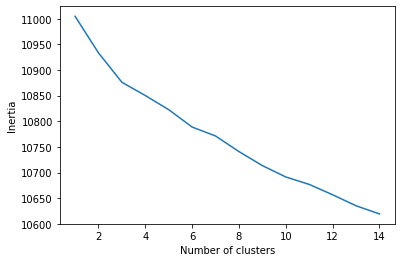

In [65]:
# cluster documents based on tf-idf scores
distortions = []
K = range(1,15)

for k in K:
    model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10)
    model.fit(X_train)
    distortions.append(model.inertia_)

plt.plot(K, distortions)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
# print(distortions)

# Choosing the best k from elbow method.
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=10)
model.fit(X_train)
tfidf_inertia = model.inertia_
print(tfidf_inertia)

Top terms per cluster:


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


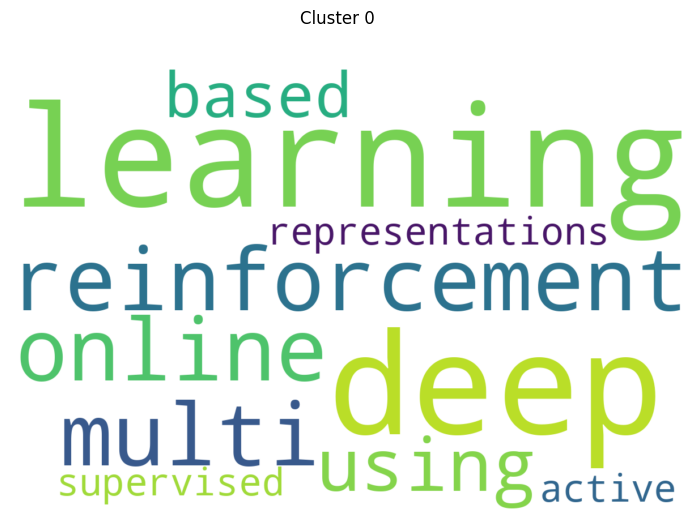

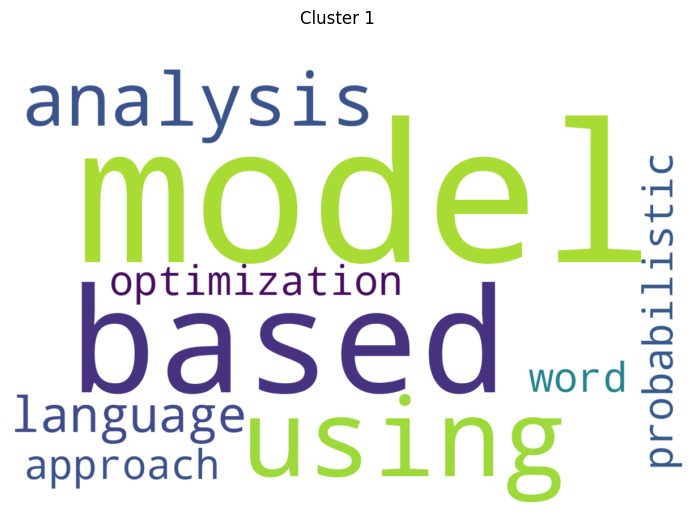

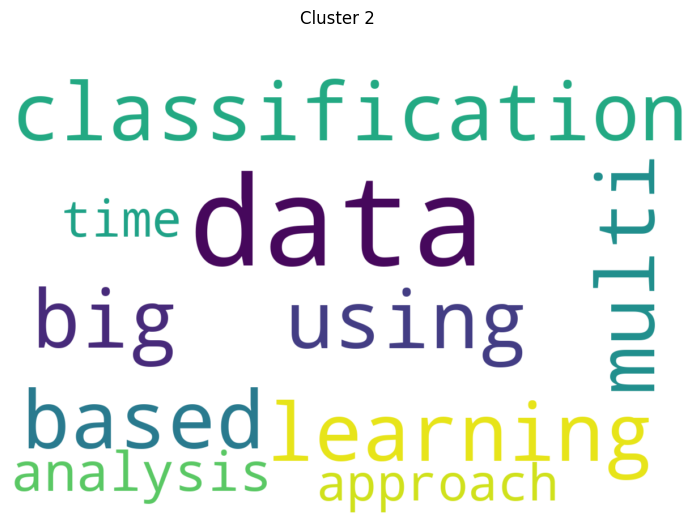

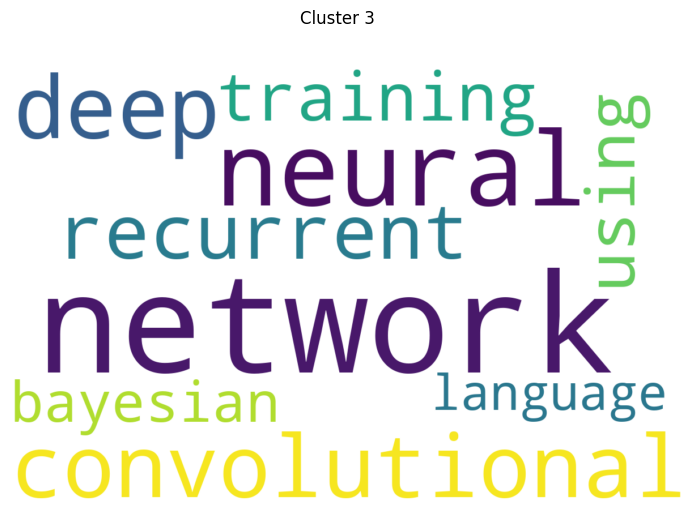

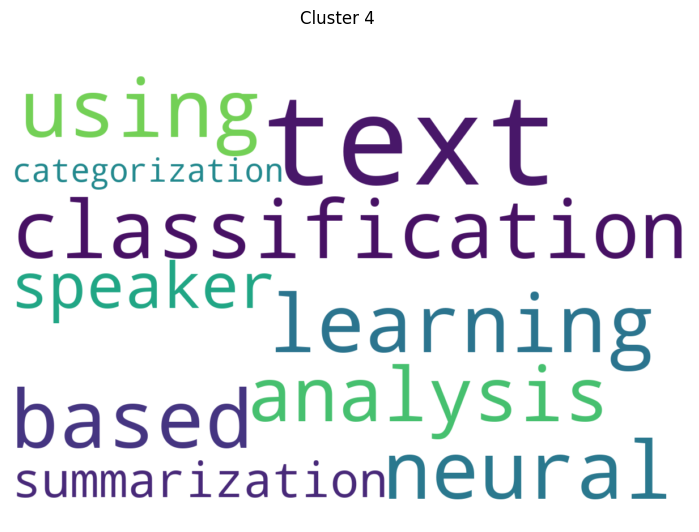

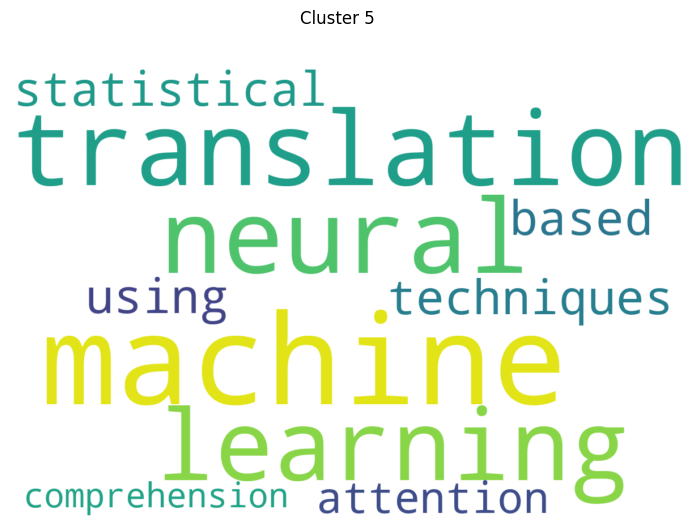

In [66]:
# Print top terms per cluster and generate word clouds
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    # print("Cluster %d:" % i)
    words = ""
    for ind in order_centroids[i, :10]:
        words = words + terms[ind] + " "
        # print (' %s' % terms[ind])
    wordcloud = WordCloud(width=1200, height=800, background_color="white").generate(words)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    fig.suptitle(f"Cluster {i}")
    plt.show()

In [67]:
# Testing the Model
# Predict the cluster association of each paper
prediction = model.predict(X_test)
print(X_train.shape)
print(X_test.shape)
df = pd.DataFrame(list(zip(test_title, prediction)), columns =['Title', 'Cluster ID'])
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# display(df)
print(df.head(10).loc[:,df.head(10).any()].to_markdown())
# display(df.loc[df['Cluster ID'] == 1])

(11090, 9172)
(637, 9172)
|    | Title                                                                                              |   Cluster ID |
|---:|:---------------------------------------------------------------------------------------------------|-------------:|
|  0 | Evaluation Metrics for Machine Reading Comprehension: Prerequisite Skills and Readability          |            5 |
|  1 | A Neural Local Coherence Model                                                                     |            3 |
|  2 | Neural Modeling of Multi-Predicate Interactions for Japanese Predicate Argument Structure Analysis |            1 |
|  3 | Neural Disambiguation of Causal Lexical Markers based on Context                                   |            1 |
|  4 | Chunk-based Decoder for Neural Machine Translation                                                 |            5 |
|  5 | What do Neural Machine Translation Models Learn about Morphology?                                  |      

### BERT Encoding

BERT stands for Bidirectional Encoder Representations from Transformers. BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.

We are using sentence-transformers package which wraps the Huggingface Transformers library. For sentence, we are using a pre-trained model 'distilbert-base-nli-stsb-mean-tokens'.

We are then using this transformation for K-means clustering to group similar papers together, and as before we use elbow method to find the optimal number of clusters needed which happens to be 6 in this case.

The number of features after BERT encoding happens to be $768$, and the total inertia for clustering is $1512914.25$. <br>
The following is the sample clustering of 10 papers from our testing dataset:

|    | Title                                                                                              |   Cluster ID |
|---:|:---------------------------------------------------------------------------------------------------|-------------:|
|  0 | Evaluation Metrics for Machine Reading Comprehension: Prerequisite Skills and Readability          |            5 |
|  1 | A Neural Local Coherence Model                                                                     |            0 |
|  2 | Neural Modeling of Multi-Predicate Interactions for Japanese Predicate Argument Structure Analysis |            2 |
|  3 | Neural Disambiguation of Causal Lexical Markers based on Context                                   |            0 |
|  4 | Chunk-based Decoder for Neural Machine Translation                                                 |            0 |
|  5 | What do Neural Machine Translation Models Learn about Morphology?                                  |            0 |
|  6 | Detecting Lexical Entailment in Context                                                            |            5 |
|  7 | Support Vector Machine Classification with Indefinite Kernels                                      |            5 |
|  8 | The Parameterized Complexity of Global Constraints                                                 |            5 |
|  9 | Examples as Interaction: On Humans Teaching a Computer to Play a Game                              |            5 |

1512914.25


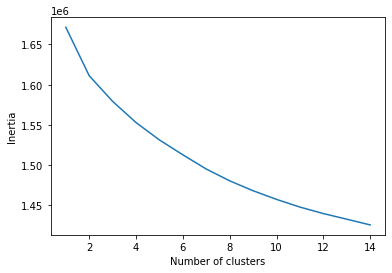

In [63]:
# BERT Encoding using SentenceTransformer and pre-trained distillbert model

embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
embeddings = embedder.encode(merged_data)
X_train = embeddings[0:len(train_data)]
X_test = embeddings[len(train_data):]

# K-means clustering on BERT encoding

bert_distortions = []
K = range(1,15)
for k in K:
    bert_model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10)
    bert_model.fit(X_train)
    bert_distortions.append(bert_model.inertia_)

plt.plot(K, bert_distortions)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
# print(distortions)

# Choosing the best k from elbow method.
true_k = 6
bert_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=10)
bert_model.fit(X_train)
bert_inertia = bert_model.inertia_
print(bert_inertia)

In [132]:
# Print top terms per cluster and generate word clouds for BERT model
print("Top terms per cluster:")
bert_order_centroids = bert_model.cluster_centers_.argsort()[:, ::-1]
terms = embeddings.get_feature_names()
for i in range(true_k):
    # print("Cluster %d:" % i)
    words = ""
    for ind in bert_order_centroids[i, :10]:
        words = words + terms[ind] + " "
        # print (' %s' % terms[ind])
    wordcloud = WordCloud(width=1200, height=800, background_color="white").generate(words)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    fig.suptitle(f"Cluster {i}")
    plt.show()

Top terms per cluster:
[-2.44336024e-01  3.19006532e-01  6.69736147e-01  4.97103371e-02
  2.52878666e-01 -3.50588948e-01  2.74452806e-01 -2.81808794e-01
 -7.81178847e-02 -1.17719638e+00  3.61000821e-02  1.08183727e-01
 -5.04054248e-01  4.83691990e-01 -1.20384470e-02  2.33392090e-01
  1.92506880e-01 -3.42532665e-01 -3.88909757e-01 -7.58971646e-03
  1.00764680e+00  1.82239145e-01 -5.99580169e-01  6.03163004e-01
  6.44917488e-01  3.04467976e-01  9.56178188e-01  1.59884858e+00
  1.46052256e-01  4.39293906e-02  6.83978975e-01 -4.89296734e-01
  4.52408940e-02 -1.15880445e-01 -7.68973827e-02 -1.16302287e-02
  4.19114262e-01 -8.13783288e-01 -2.54536241e-01  1.51119933e-01
  2.77184099e-01  1.86565071e-01  1.32472634e-01  3.66769135e-01
 -3.34384531e-01 -1.43240497e-01 -9.17086542e-01  3.53527576e-01
 -1.35454488e+00  4.73264419e-02 -9.60772276e-01 -5.69244176e-02
  1.41296372e-01 -4.78532195e-01 -7.17547297e-01 -4.29592952e-02
 -5.49104810e-01 -1.22804776e-01  1.47263253e+00  1.11831546e-01
 -

AttributeError: 'numpy.ndarray' object has no attribute 'get_feature_names'

In [129]:
# Predict the clusters using BERT encoded model
bert_prediction = bert_model.predict(X_test)
print(X_train.shape)
print(X_test.shape)
bert_df = pd.DataFrame(list(zip(test_title, prediction)), columns =['Title', 'Cluster ID'])
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# display(df)
print(bert_df.head(10).loc[:,bert_df.head(10).any()].to_markdown())
# display(df.loc[df['Cluster ID'] == 1])

(11090, 768)
(637, 768)
|    | Title                                                                                              |   Cluster ID |
|---:|:---------------------------------------------------------------------------------------------------|-------------:|
|  0 | Evaluation Metrics for Machine Reading Comprehension: Prerequisite Skills and Readability          |            5 |
|  1 | A Neural Local Coherence Model                                                                     |            0 |
|  2 | Neural Modeling of Multi-Predicate Interactions for Japanese Predicate Argument Structure Analysis |            2 |
|  3 | Neural Disambiguation of Causal Lexical Markers based on Context                                   |            0 |
|  4 | Chunk-based Decoder for Neural Machine Translation                                                 |            0 |
|  5 | What do Neural Machine Translation Models Learn about Morphology?                                  |        